In [ ]:
pip install spacy

In [1]:
import pandas as pd
import numpy as np
import re
import os
import torch
import pickle
import sklearn
import keras
import spacy
from tqdm import tqdm
from transformers import AutoModel,AutoTokenizer
from nltk.corpus import stopwords
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModel, BertModel, AutoTokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import time
import pandas as pd
import numpy as np
import re
import os
import torch
import pickle
import sklearn
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoModel,AutoTokenizer
from nltk.corpus import stopwords
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModel, BertModel, AutoTokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Some funcs

In [3]:
stemmer = SnowballStemmer('russian')

stop_words = stopwords.words('english')

def doc_prepr(df, column_name='text'):
    new_df = df

    for i, text in tqdm(enumerate(df[column_name])):
        if (len(text) < 10):
            text = ''
        text = re.sub(r'[\n\t]+(\d){1,3}(?=[\n\t])', '', text)
        text = re.sub(r'(?<!\.)( *(\n|\t) *)(?=[A-ZРђ-РЇРЃ])', '.\g<1>', text)
        text = re.sub(r'(?<!\.)( *(\n|\t) *)(\d{1,3} *([\.\)/][\.\)\d/]*)* *)(?=[A-ZРђ-РЇРЃ])', '.\g<1>\g<3>', text)
        text = re.sub(r'(?<!\.)( *(\n|\t) *)([A-Za-zРђ-РЇРЃР°-СЏС‘][\.\)] *)(?=[A-ZРђ-РЇРЃ])', '.\g<1>\g<3>', text)
        text = re.sub(r'((\t)|(\n))ERROR:#.{,10}?!', '', text)
        text = re.sub(r'\.+', '.', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'_+', ' ', text)

        new_df.loc[i, 'text'] = text

    return new_df


def preprocessing(text, tokenizer, stop_words, lemm, stem, del_sw=False):
        text = str(text)
        text = text.lower()
        text = re.sub(r'([^\s\w])', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        text = re.sub(r'_', ' ', text)
        text = re.sub(r'№', 'номер ', text)
        text = re.sub(r"\s+", ' ', text)
        text = re.sub(r' \.', '.', text)
        text = re.sub(r'\.([^\s])', '. \g<1>', text)
        text = re.sub(r"^\s$", '', text)
        text = tokenizer(text)
        if del_sw:
                text = del_stopwords(text, stop_words)
        if lemm:
                text = lemmatize(text)
        if stem:
                text = stemm(text)

        return ' '.join(text)


def remove_fio(text):
    text = str(text)
    text = re.sub(r'[Рђ-РЇРЃ]\.\s*[Рђ-РЇРЃ]\.\s*[Рђ-РЇРЃ][Рђ-РЇР°-СЏРЃС‘]+', '', text)
    text = re.sub(r'[Рђ-РЇРЃ][Рђ-РЇР°-СЏРЃС‘]+?\s*[Рђ-РЇРЃ]\.\s*[Рђ-РЇРЃ]([\.\s]|$)', '', text)
    text = re.sub(r'[Рђ-РЇ][Р°-СЏС‘]+\s*[Рђ-РЇ][Р°-СЏС‘]+\s*[Рђ-РЇ][Р°-СЏС‘]+', ' ', text)
    text = re.sub(
        r'[Р°-СЏС‘]+?((РѕРІ)|(РµРІ)|(С‘РІ)|(РёРЅ)|(СЏРЅ)|(РµРЅРєРѕ)|(СѓРє)|(СЋРє)|(Р°Р»Рѕ)|(РµР»Рѕ)|(РґР·Рµ)|(РёР»Рё)|(РєРѕ)|(РІРёС‡)|(РёС…)|(СЃРєРёР№)|(СЃРєР°СЏ))(Р°)?\s+[Р°-СЏС‘]+?\s+[Р°-СЏС‘]+?((РІРёС‡)|(РІРЅР°))',
        ' ', text, flags=re.I)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


def del_stopwords(word_list, stop_words):
        new_word_list = [word for word in word_list if word not in stop_words and len(word) > 2]
        return new_word_list


def stemm(word_list):
        stem_word_list = [stemmer.stem(word) for word in word_list]
        return stem_word_list

def lemmatize(text_data):
    nlp = spacy.load("en_core_web_sm")
    doc = ' '.join(text_data)
    doc = nlp(doc)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

def sentenize(df, column_name='text', first_tokens_num=2000):
    for i, doc in enumerate(df[column_name]):
        df.loc[i, column_name] = ' '.join(doc.split()[:first_tokens_num])
        fnames, sents = [], []

    for i, doc_name in tqdm(enumerate(df['fname'])):
        cur_sents = [j.text for j in list(razdel.sentenize(df.loc[i, 'text'])) if bool(re.search(r'[Р°-СЏС‘]{3,}', j.text, re.I))]
        fnames.extend([doc_name] * len(cur_sents))
        sents.extend(cur_sents)

    new_df = pd.DataFrame({'fname': fnames, 'sent': sents})

    return new_df

def labse_vectorize(sents, model_tokenizer, model_vectorizer, batch_size=100, cuda=False):
    if cuda:
        device = torch.device('cuda', 0)
        model_vectorizer = model_vectorizer.to(device)
    else:
        device = 'cpu'
    labse_vectors = np.zeros((len(sents), 768))
    batch_count = len(sents)//batch_size + int(bool(len(sents)%batch_size))
    idx = 0
    for i in tqdm(range(batch_count)):
        cur_sents = sents[i*batch_size:i*batch_size+batch_size]
        cur_sents = list(map(str,cur_sents))
        with torch.no_grad():
            tokenized_sent = model_tokenizer(cur_sents, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
            sent_embedding = model_vectorizer(**tokenized_sent).pooler_output.to('cpu')
        labse_vectors[i*batch_size:i*batch_size+batch_size,:] = sent_embedding.detach().numpy()
        with torch.no_grad():
            del(tokenized_sent)
            del(sent_embedding)
        torch.cuda.empty_cache()

    return labse_vectors


def my_cross_validate(df, ml_model, kfold_model, vectors, target_col_name, save_test=True, print_res=True, oversampling=False, undersampling=False, random_state=1):
    start = time.time()

    X = vectors
    y = df[target_col_name]

    if oversampling:
        smote_dict = {i:y.value_counts()[i]*10 for i in np.unique(y) if i!=0}
        smote = SMOTE(sampling_strategy=smote_dict, random_state=1, k_neighbors=5, n_jobs=1)
        X, y = smote.fit_resample(X, y)

    indices = kfold_model.split(X,y)

    clf = ml_model
    y_preds = []
    classification_reports = []

    precision_scores = []
    recall_scores = []
    f1_scores = []
    test_dfs = []

    if len(y.unique()) > 2:
        average_param = 'macro'
        classification_report_ = True
    else:
        average_param = 'binary'
        classification_report_ = False

    for i, (train_index, test_index) in tqdm(enumerate(indices)):
        # print(f'Fold №: {i}')

        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        if (undersampling):
            und_samp_dict = {i:int(y_train.value_counts()[i]//10) for i in np.unique(y) if i==0}
            und_sampler = RandomUnderSampler(sampling_strategy=und_samp_dict,random_state=42)
            X_train, y_train = und_sampler.fit_resample(X_train, y_train)


        clf.fit(X_train, y_train)
        y_preds.append(clf.predict(X_test))

        if (save_test):
            temp_df = df.copy()
            temp_df = temp_df.loc[test_index]
            temp_df['pred_tag'] = y_preds[i]
            test_dfs.append(temp_df)

        labels = y_test

        if classification_report_:
            classification_reports.append(classification_report(labels, y_preds[i], output_dict=True))

        prec_score = precision_score(labels, y_preds[i], average=average_param)
        rec_score = recall_score(labels, y_preds[i], average=average_param)
        f1_scor = f1_score(labels, y_preds[i], average=average_param)
        precision_scores.append(prec_score)
        recall_scores.append(rec_score)
        f1_scores.append(f1_scor)

        if (print_res==False):
            return

    res_avg_metrics = pd.DataFrame({'model': [str(clf).split('(')[0]], 'avg_precision': np.array(precision_scores).mean(), 'avg_recall': np.array(recall_scores).mean(), 'avg_f1': np.array(f1_scores).mean(), 'class_report':[classification_reports]})

    end = time.time() - start
    print(f'time for predictions:{end}')
    return res_avg_metrics, test_dfs


In [4]:
df = pd.read_csv('df_file.csv')

## Dataset description

In [ ]:
a = 'Army chiefs in regiments decision\n \n Military chiefs are expected to meet to make a final decision on the future of Scotland\'s Army regiments.\n \n A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland\'s six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee\'s decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair.'
preprocessing(a, word_tokenize, stop_words=stop_words, lemm=True, stem=False, del_sw=True)

'army chiefs regiment decision military chief expect meet make final decision future scotland army regiments committee army board make senior defence figure discuss plan restructure regiment monday proposal include cut scotland six single battalion regiment five merge super regiment plan face stiff opposition campaigner politician alike committee decision must ratify defence secretary geoff hoon prime minister tony blair'

In [ ]:
df["Text"].loc[1]

'Army chiefs in regiments decision\n \n Military chiefs are expected to meet to make a final decision on the future of Scotland\'s Army regiments.\n \n A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland\'s six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee\'s decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair. It is expected that it will be made public next week. When ministers announced a reorganisation of the Army it drew a question mark over the futures of the Black Watch, the Kings Own Scottish Borderers, the Royal Scots, the Royal Highland Fusiliers and the Argyll and Sutherland Highlanders. In October, the Council of Scottish Colonels proposed the merger of the Royal Scots and the King\'s Own Scot

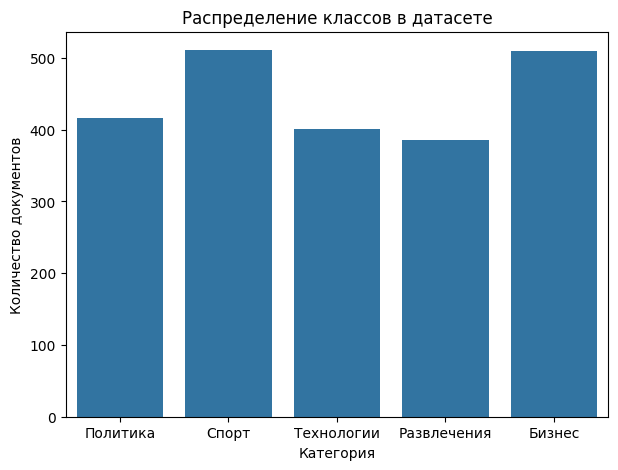

In [ ]:
# построим график распределений классов
def plot_class_distribution(labels):
  class_counts = Counter(labels)
  plt.figure(figsize=(7, 5))
  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
  plt.title('Распределение классов в датасете')
  plt.xlabel('Категория')
  plt.ylabel('Количество документов')
  plt.show()

labels = {0:'Политика', 1:'Спорт', 2:'Технологии', 3:'Развлечения', 4:'Бизнес'}
plot_class_distribution(df['Label'].apply(lambda x:labels[x]))

In [ ]:
average_lengths = df.groupby('Label')['length'].mean().reset_index()

average_lengths.columns = ['Класс', 'Средняя длина документа']

# Вывод результатов
print(average_lengths)

   Класс  Средняя длина документа
0      0              2695.824940
1      1              1906.545988
2      2              2987.690773
3      3              1938.230570
4      4              1996.194118


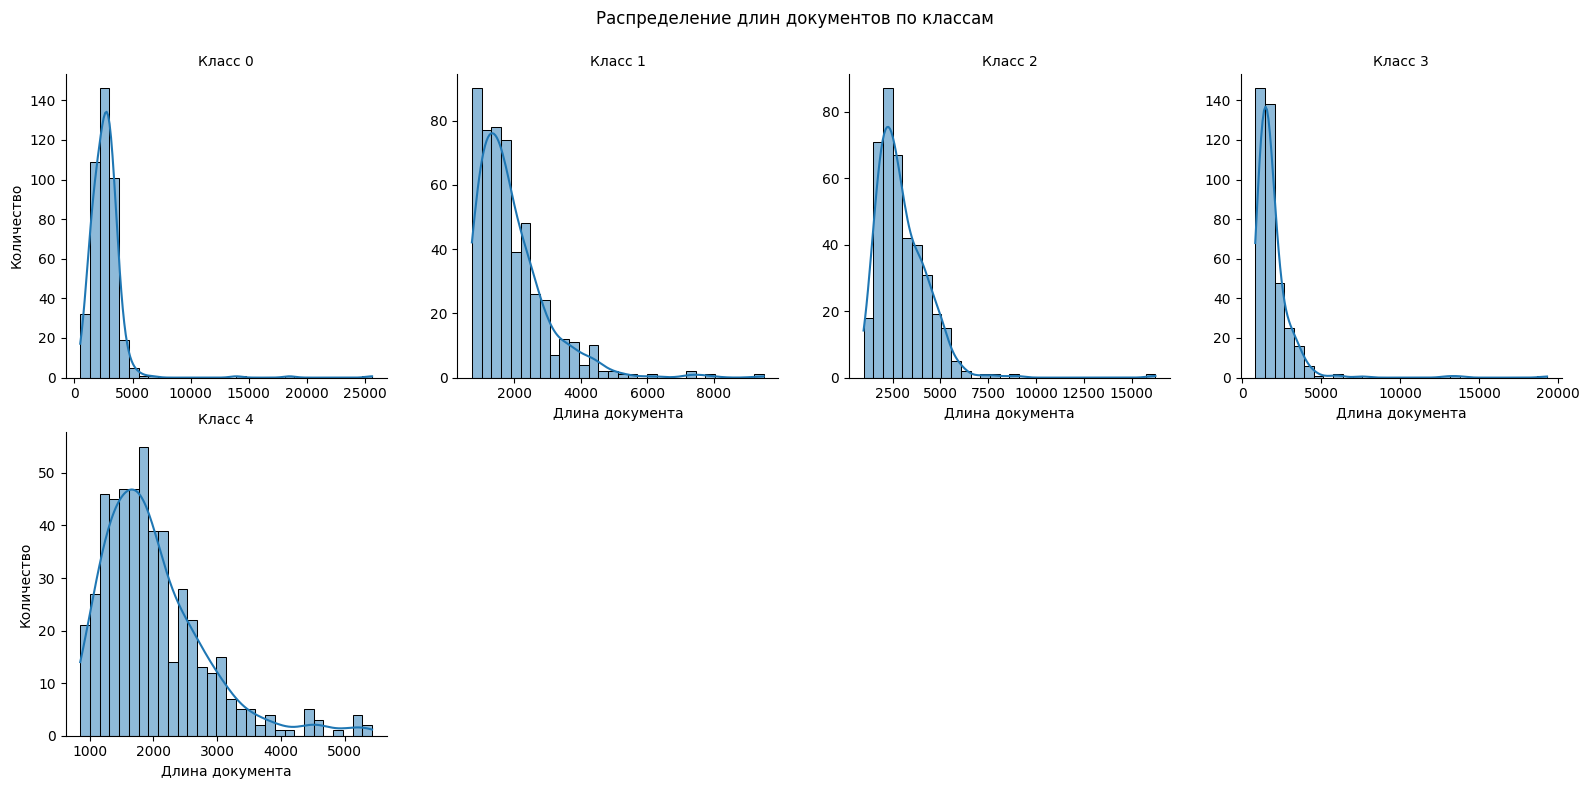

In [ ]:
g = sns.FacetGrid(df, col='Label', col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, 'length', bins=30, kde=True)

g.set_axis_labels('Длина документа', 'Количество')
g.set_titles('Класс {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Распределение длин документов по классам')

plt.show()

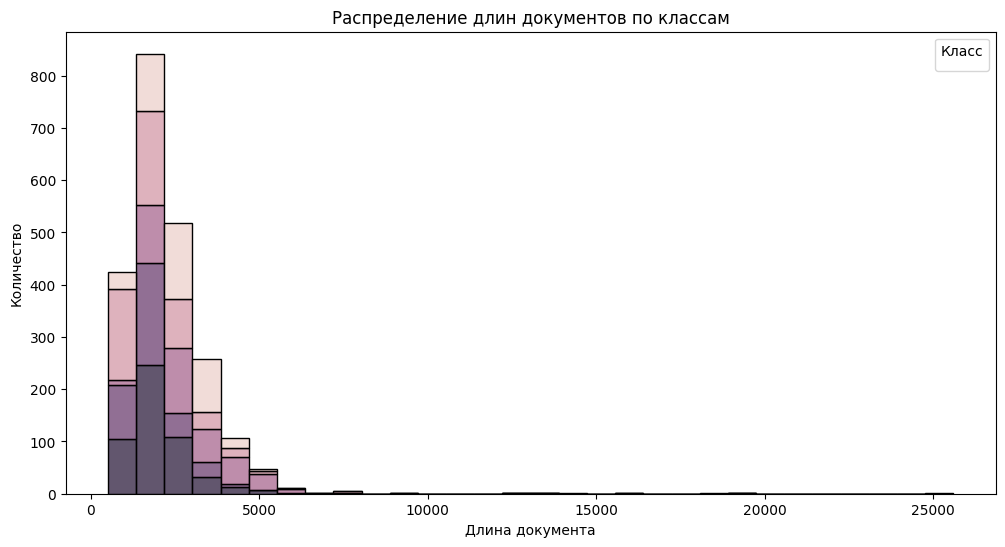

In [ ]:
df['length'] = df['Text'].apply(len)

# Построение графиков распределения длин документов для каждого класса
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='length', hue='Label', multiple='stack', bins=30)
plt.xlabel('Длина документа')
plt.ylabel('Количество')
plt.title('Распределение длин документов по классам')
plt.legend(title='Класс')
plt.show()

## Preprocessing

In [ ]:
while max(df['length']<6000):
  i = np.where(df['length'] == max(df['length']))
  df = df.drop(labels=[i]).reset_index(drop=True)

In [ ]:
df = df.drop(labels=[843]).reset_index(drop=True)

In [ ]:
print(max(df['length']))
np.where(df['length'] == max(df['length']))

7360


(array([623]),)

### W2V

In [ ]:
pip install razdel

In [ ]:
import razdel
texts = df['Text']
def preprocess_sentence(sentence):
    tokens = [token.text.lower() for token in razdel.tokenize(sentence)]
    return [token for token in tokens if token not in stop_words and token.isalpha()]

sentences = [preprocess_sentence(sent.text) for text in texts for sent in razdel.sentenize(text)]

In [ ]:
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=2)

# Функция для получения вектора предложения
def sentence_vector(sentence):
    words = [word for word in sentence if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

# Векторизация предложений в каждом документе и усреднение векторов по документам
doc_vectors = [np.mean([sentence_vector(sentence) for sentence in tqdm(preprocess_sentence(text))], axis=0) for text in texts]
len(doc_vectors)

100%|██████████| 188/188 [00:00<00:00, 18735.25it/s]


2225

In [ ]:
from gensim.models import Word2Vec

sentences = [word_tokenize(doc) for doc in stem_corpus]
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=2)

def document_vector(doc):
    doc = [word for word in doc if word in model.wv]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    # Взятие среднего всех векторов слов
    return np.mean(model.wv[doc], axis=0)

# Векторизация всех документов
W2V_vectors = [document_vector(doc) for doc in sentences]

### TF-IDF

## Stemming

In [ ]:
# составляем корпус текстов
corpus = list(df['Text'])

# инициализация tf-idf векторайзера
tf_idf_vectorizer_multi = TfidfVectorizer(max_features=5000, ngram_range=(1,3), max_df=0.98)

# предобработка данных
stem_corpus = [preprocessing(corpus[i], word_tokenize, stop_words,
                             del_sw=True, lemm=False, stem=True) for i in tqdm(range(len(corpus)))]

# получение tf-idf векторов
tf_idf_vectors_stemm = tf_idf_vectorizer_multi.fit_transform(stem_corpus)


100%|██████████| 2225/2225 [00:16<00:00, 136.87it/s]


## Lemmatization

In [ ]:
lemm_corpus = list(df['Text'])

# предобработка данных
lemm_corpus = [preprocessing(corpus[i], word_tokenize, stop_words,
                             del_sw=True, lemm=True, stem=False) for i in tqdm(range(len(corpus)))]

# инициализация tf-idf векторайзера
tf_idf_vectorizer_multi = TfidfVectorizer(max_features=5000, ngram_range=(1,3), max_df=0.98)

# получение tf-idf векторов
tf_idf_vectorizer_multi = TfidfVectorizer(max_features=5000, ngram_range=(1,3), max_df=0.98)
tf_idf_vectors_lemm = tf_idf_vectorizer_multi.fit_transform(lemm_corpus)

# обучение с tf-idf векторами и лемматизацией
X = tf_idf_vectors_lemm
y = df['Label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(C= 1, penalty= 'none', solver= 'saga')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [2212, 2225]

## LogReg/LGBM

### GridSearch for logReg

In [ ]:
# обучение с W2V векторами и сентенизацией
X = doc_vectors
y = df['Label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(C= 1, penalty= 'none', solver= 'saga')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.45      0.33      0.38        92
           1       0.44      0.54      0.49        98
           2       0.30      0.25      0.27        77
           3       0.42      0.49      0.45        76
           4       0.36      0.38      0.37       102

    accuracy                           0.40       445
   macro avg       0.40      0.40      0.39       445
weighted avg       0.40      0.40      0.39       445



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# обучение с W2V векторами
X = W2V_vectors
y = df['Label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(C= 1, penalty= 'none', solver= 'saga')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.79      0.82        92
           1       0.80      0.88      0.84        98
           2       0.77      0.70      0.73        77
           3       0.78      0.74      0.76        76
           4       0.75      0.80      0.77       102

    accuracy                           0.79       445
   macro avg       0.79      0.78      0.78       445
weighted avg       0.79      0.79      0.79       445



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# обучение с tf-idf векторами
vectorizer = TfidfVectorizer(max_features=5000)
# X = vectorizer.fit_transform(stem_corpus)
X = tf_idf_vectors_stemm
y = df['Label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(C= 1, penalty= 'none', solver= 'saga')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.96      0.97        92
           1       0.99      1.00      0.99        98
           2       0.99      0.99      0.99        77
           3       0.97      0.99      0.98        76
           4       0.98      0.98      0.98       102

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))

0.9818215771156948
0.982153797653865


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(stem_corpus)
y = df['Label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели и параметров для поиска
model = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Поиск по сетке
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Оценка на тестовых данных
y_pred = grid_search.predict(X_test)
print("Точность на тестовых данных:", precision_recall_fscore_support(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following err

Лучшие параметры: {'C': 1, 'penalty': 'none', 'solver': 'saga'}
Точность на тестовых данных: 0.9706546275395034


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### GridSearch for xgb

In [ ]:
X = tf_idf_vectors_stemm
y = df['Label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = LGBMClassifier(num_leaves=31, learning_rate= 0.1, n_estimators=150,boosting_type = 'goss', max_depth= 3, min_child_samples=5)

xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
# print(precision_score(y_test, y_pred, average='macro'))
# print(recall_score(y_test, y_pred, average='macro'))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.254189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81150
[LightGBM] [Info] Number of data points in the train set: 1780, number of used features: 4922
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -1.700543
[LightGBM] [Info] Start training from score -1.460921
[LightGBM] [Info] Start training from score -1.703625
[LightGBM] [Info] Start trai

In [ ]:
# Определение модели и параметров для поиска
model = LGBMClassifier()
param_dist = {
    'num_leaves': [31, 50, 75, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 125, 150, 200],
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'objective': ['binary', 'multiclass'],
    'max_depth': [3, 5, 7, 10],
    'min_child_samples': [5, 7, 10, 13]
}

X = tf_idf_vectors_stemm
y = df['Label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Случайный поиск
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

# Оценка на тестовых данных
y_pred = random_search.predict(X_test)
print("Точность на тестовых данных:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
260 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
260 fits failed with the following er

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79485
[LightGBM] [Info] Number of data points in the train set: 1780, number of used features: 4454
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -1.700543
[LightGBM] [Info] Start training from score -1.460921
[LightGBM] [Info] Start training from score -1.703625
[LightGBM] [Info] Start trai

In [ ]:
lr_preds = log_reg.predict(X_test)
lgbm_preds = lgbm.predict(X_test)

accuracy = accuracy_score(y_test, lr_preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, lr_preds, average='weighted')
precision, recall, f1
print(precision, recall, f1)

accuracy = accuracy_score(y_test, lgbm_preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, lgbm_preds, average='weighted')
precision, recall, f1

0.9759179695454627 0.9752808988764045 0.9753691662765411


(0.9531324456476693, 0.952808988764045, 0.9527111876673326)

## CNN

In [6]:
max_features = 5000
max_len = 2000

train_df, test_df = train_test_split(df, test_size=0.2)

# токенезация и векторизация
keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(df['Text'].apply(lambda x: preprocessing(x, word_tokenize, stop_words,del_sw=True, lemm=False, stem=True)))

# деление на части
sequence_train = keras_tokenizer.texts_to_sequences(train_df['Text'])
sequence_test = keras_tokenizer.texts_to_sequences(test_df['Text'])

# padding последовательностей
X_train = keras.utils.pad_sequences(sequence_train, max_len, padding='post')
X_test = keras.utils.pad_sequences(sequence_test, max_len, padding='post')

y_train = keras.utils.to_categorical(train_df['Label'])
y_test = keras.utils.to_categorical(test_df['Label'])

cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
cnn_model.add(keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
cnn_model.add(keras.layers.MaxPool1D(pool_size=3))
cnn_model.add(keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(keras.layers.MaxPool1D(pool_size=3))
cnn_model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dropout(0.3))
cnn_model.add(keras.layers.Dense(20, activation='relu'))
cnn_model.add(keras.layers.Dropout(0.3))
cnn_model.add(keras.layers.Dense(len(y_train[0]), activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()

cnn_model.fit(X_train, y_train, batch_size=32, epochs=20)

end = time.time() - start
print(f'CNN train time:{end}')

cnn_preds = cnn_model.predict(X_test)
cnn_preds = [np.argmax(pred) for pred in cnn_preds]
y_test = [np.argmax(i) for i in y_test]

accuracy = accuracy_score(y_test, cnn_preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, cnn_preds, average='weighted')
precision, recall, f1

Epoch 1/20
56/56 [==============================] - 23s 395ms/step - loss: 1.6077 - accuracy: 0.2101
Epoch 2/20
56/56 [==============================] - 22s 399ms/step - loss: 1.4368 - accuracy: 0.3635
Epoch 3/20
56/56 [==============================] - 23s 406ms/step - loss: 0.6742 - accuracy: 0.7545
Epoch 4/20
56/56 [==============================] - 22s 396ms/step - loss: 0.2579 - accuracy: 0.9152
Epoch 5/20
56/56 [==============================] - 24s 426ms/step - loss: 0.1368 - accuracy: 0.9528
Epoch 6/20
56/56 [==============================] - 20s 365ms/step - loss: 0.0888 - accuracy: 0.9736
Epoch 7/20
56/56 [==============================] - 22s 395ms/step - loss: 0.0727 - accuracy: 0.9770
Epoch 8/20
56/56 [==============================] - 20s 349ms/step - loss: 0.0500 - accuracy: 0.9854
Epoch 9/20
56/56 [==============================] - 22s 396ms/step - loss: 0.0463 - accuracy: 0.9860
Epoch 10/20
56/56 [==============================] - 21s 368ms/step - loss: 0.0379 - accura

(0.9503705169886967, 0.9438202247191011, 0.9438985435809998)

In [ ]:
max_features = 5000
max_len = 2000

train_df, test_df = train_test_split(df, test_size=0.2)

# токенезация и векторизация
keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(df['Text'])

# деление на части
sequence_train = keras_tokenizer.texts_to_sequences(train_df['Text'])
sequence_test = keras_tokenizer.texts_to_sequences(test_df['Text'])

# padding последовательностей
X_train = keras.utils.pad_sequences(sequence_train, max_len, padding='post')
X_test = keras.utils.pad_sequences(sequence_test, max_len, padding='post')

y_train = keras.utils.to_categorical(train_df['Label'])
y_test = keras.utils.to_categorical(test_df['Label'])

cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
cnn_model.add(keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
cnn_model.add(keras.layers.MaxPool1D(pool_size=3))
cnn_model.add(keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(keras.layers.MaxPool1D(pool_size=3))
cnn_model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dropout(0.3))
cnn_model.add(keras.layers.Dense(20, activation='relu'))
cnn_model.add(keras.layers.Dropout(0.3))
cnn_model.add(keras.layers.Dense(len(y_train[0]), activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()

cnn_model.fit(X_train, y_train, batch_size=32, epochs=20)

end = time.time() - start
print(f'CNN train time:{end}')

cnn_preds = cnn_model.predict(X_test)
cnn_preds = [np.argmax(pred) for pred in cnn_preds]
y_test = [np.argmax(i) for i in y_test]


Epoch 1/20
56/56 [==============================] - 38s 633ms/step - loss: 1.6026 - accuracy: 0.2281
Epoch 2/20
56/56 [==============================] - 24s 420ms/step - loss: 1.4982 - accuracy: 0.3461
Epoch 3/20
56/56 [==============================] - 20s 363ms/step - loss: 1.0798 - accuracy: 0.5444
Epoch 4/20
56/56 [==============================] - 22s 383ms/step - loss: 0.6908 - accuracy: 0.7146
Epoch 5/20
56/56 [==============================] - 20s 362ms/step - loss: 0.4596 - accuracy: 0.7949
Epoch 6/20
56/56 [==============================] - 23s 405ms/step - loss: 0.3071 - accuracy: 0.8758
Epoch 7/20
56/56 [==============================] - 20s 357ms/step - loss: 0.1793 - accuracy: 0.9455
Epoch 8/20
56/56 [==============================] - 22s 400ms/step - loss: 0.1368 - accuracy: 0.9506
Epoch 9/20
56/56 [==============================] - 22s 402ms/step - loss: 0.1063 - accuracy: 0.9629
Epoch 10/20
56/56 [==============================] - 22s 386ms/step - loss: 0.0759 - accura

In [ ]:
accuracy = accuracy_score(y_test, cnn_preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, cnn_preds, average='weighted')
precision, recall, f1

(0.9617829176395223, 0.9617977528089887, 0.9617412658598312)

## RNN

### Vectorization

In [ ]:
encoder = keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(df['Text'])

vocabulary = np.array(encoder.get_vocabulary())

example = df.loc[0, 'Text']
original_text = example
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])
print(encoded_text)

[ 429    3  113 2127    8  133  729  223   23 1465    3  183    2  196
   21    2  544    4  756  500    8    6  241  877    7  416   64   16
    1   30 4932  429   21    1 1548   16    9  177    3 4476    2 2935
    4 1183  225 2080   17  602 1413    5  346  547    2  410    9  177
    3 3481 4510 1500    5  935    2 3654 1500 4658   26    1   24    2
  970    5  591 1050 3584  735  392  597  786    5   41    1  167  120
 1736  827   20   12   51   23   27   15    6 3348 8763   24   31  223
    9  388    3   20   49 7653    3 5600  365    7    2 3654 1500 4658
   26    1    6 3481   11 4510 1500   34 4977    4  217  940 1056    8
 4507 1379  493  209    8 2922    2 3654 1500 4658  306    9 2137    3
  209   65   68 2891    6  271 3136    4   58  105    4    2  532  625
  252  133    1 2161   66  439 2891   37    6  134 1358  423    4 4431
 3654 1500   17  538    3  386    6  142 3560    7  155    5  226 1558
 1261    8  334   56    1  136  126  811   80 1415  326   20   41   56
 3721 

In [ ]:
rnn_model = keras.Sequential([
    keras.layers.Embedding(len(encoder.get_vocabulary()) 64, mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64,  return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(np.unique(df['Label'])), activation='softmax')
])

rnn_model.summary()

rnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 751749 (2.87 MB)
Trainable params: 75174

In [ ]:
# делим на train и test
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Label'])

# создаем и обучаем векторайзер
encoder = keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(df['Text'])
vocabulary = np.array(encoder.get_vocabulary())

# токенизируем выборки
x_train = [encoder(doc).numpy() for doc in train_df['Text']]
x_test = [encoder(doc).numpy() for doc in test_df['Text']]

# паддим полученные вектора
x_train = pad_sequences(x_train, maxlen=500)
x_test = pad_sequences(x_test, maxlen=500)

y_train = train_df['Label']
y_test = test_df['Label']

In [ ]:
# обучение модели
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01)
start = time.time()
rnn_model.fit(x=x_train, y=y_train, epochs=10, callbacks=[callback])
end = time.time() - start
print(f'RNN train time:{end}')

Epoch 1/10
49/49 [==============================] - 93s 1s/step - loss: 1.5115 - accuracy: 0.3475
Epoch 2/10
49/49 [==============================] - 71s 1s/step - loss: 0.7934 - accuracy: 0.7001
Epoch 3/10
49/49 [==============================] - 72s 1s/step - loss: 0.3232 - accuracy: 0.9139
Epoch 4/10
49/49 [==============================] - 73s 1s/step - loss: 0.1922 - accuracy: 0.9480
Epoch 5/10
49/49 [==============================] - 73s 2s/step - loss: 0.1169 - accuracy: 0.9621
Epoch 6/10
49/49 [==============================] - 73s 1s/step - loss: 0.1227 - accuracy: 0.9621
CNN train time:455.54974007606506


In [ ]:
# предсказания модели
preds = model.predict(x=x_test)

21/21 [==============================] - 13s 258ms/step


In [ ]:
preds = [np.argmax(pred) for pred in preds]

In [ ]:
print(sklearn.metrics.classification_report(y_true=y_test, y_pred=preds))

              precision    recall  f1-score   support

           0       0.74      0.93      0.83       125
           1       1.00      0.90      0.95       154
           2       0.70      0.88      0.78       120
           3       0.83      0.82      0.82       116
           4       1.00      0.70      0.82       153

    accuracy                           0.84       668
   macro avg       0.85      0.85      0.84       668
weighted avg       0.87      0.84      0.84       668

